## Part 3: Neural Networks Utilizing Randomized Pruning

In [106]:
! pip install -q tensorflow-model-optimization

In [110]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow_model_optimization.python.core.keras.compat import keras

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [107]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


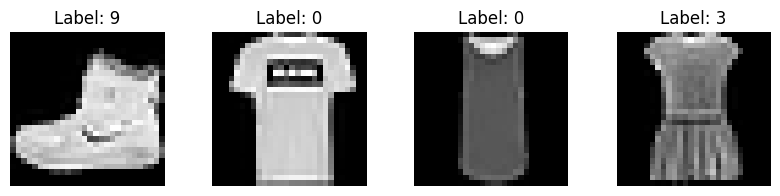

In [111]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Create a figure with a single row of subplots
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(10, 2))

# Display the images and their labels
for i in range(num_images):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].set_title(f'Label: {train_labels[i]}')
    axes[i].axis('off')

# plt.savefig('/content/gdrive/MyDrive/24X/M76/Final_Project_Code/MNIST_fashon_labels.png')

Below we define our 5 different neural networks. Their stratagies are summarized in Table 3 of our write up.

In [118]:
# NO PRUNING
class NoPruningLayer(tf.keras.layers.Layer):
    '''
    A class for a layer which does not apply any pruning
    '''
    def __init__(self, layer, **kwargs):
        '''
        Constructor for the layer

        Parameters:
        - layer: The layer to be used without pruning
        '''
        super(NoPruningLayer, self).__init__(**kwargs)
        self.layer = layer

    def build(self, input_shape):
        '''
        Builds the layer

        Parameters:
        - input_shape: The shape of the input
        '''
        super(NoPruningLayer, self).build(input_shape)
        self.layer.build(input_shape)

    def call(self, inputs, training=None):
        '''
        Calls the layer

        Parameters:
        - inputs: The inputs to the layer
        - training: Whether the layer is in training mode
        '''
        # Simply pass through the weights without pruning
        return self.layer(inputs)

    def get_config(self):
        '''
        Returns the config of the layer
        '''
        config = super(NoPruningLayer, self).get_config()
        config.update({
            'layer': self.layer,  # Ensure this layer can be serialized correctly
        })
        return config


In [124]:
def create_no_pruning_model(input_shape=(28, 28)):
    '''
    Creates a model with a no pruning layer

    Parameters:
    - input_shape: The shape of the input

    Returns:
    - A model with a no pruning layer
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        NoPruningLayer(tf.keras.layers.Conv2D(12, (3, 3), activation='relu')),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])
    return model

# Define and compile the model
model_for_no_pruning = create_no_pruning_model()

model_for_no_pruning.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                             metrics=['accuracy'])

model_for_no_pruning.summary()

# Train the model with no pruning
model_for_no_pruning.fit(train_images, train_labels,
                         batch_size=batch_size, epochs=4, validation_split=validation_split)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_17 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ no_pruning_layer (NoPruningLayer)    │ (None, 26, 26, 12)          │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 13, 13, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 2028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 10)                  │          20,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,410 (79.73 KB)

 Trainable params: 20,410 (79.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.7058 - loss: 0.9532 - val_accuracy: 0.8508 - val_loss: 0.4222
Epoch 2/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8592 - loss: 0.4078 - val_accuracy: 0.8680 - val_loss: 0.3704
Epoch 3/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8747 - loss: 0.3605 - val_accuracy: 0.8732 - val_loss: 0.3518
Epoch 4/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.8826 - loss: 0.3375 - val_accuracy: 0.8772 - val_loss: 0.3394


In [117]:
# DETERMINISTIC PRUNING
class DeterministicPruningLayer(tf.keras.layers.Layer):
    '''
    A class for a layer which prunes deterministically
    '''
    def __init__(self, layer, sparsity, **kwargs):
        '''
        Constructor for the layer

        Parameters:
        - layer: The layer to be pruned
        - sparsity: The sparsity of the layer
        '''
        super(DeterministicPruningLayer, self).__init__(**kwargs)
        self.layer = layer
        self.sparsity = sparsity

    def build(self, input_shape):
        '''
        Builds the layer

        Parameters:
        - input_shape: The shape of the input
        '''
        super(DeterministicPruningLayer, self).build(input_shape)
        self.layer.build(input_shape)

    def call(self, inputs, training=None):
        '''
        Calls the layer

        Parameters:
        - inputs: The inputs to the layer
        - training: Whether the layer is in training mode
        '''
        weights = self.layer.kernel
        if training:
            # Flatten the weights to apply threshold-based pruning
            flattened_weights = tf.reshape(weights, [-1])

            # Determine the threshold for pruning
            num_weights = tf.size(flattened_weights)
            k = tf.cast(self.sparsity * tf.cast(num_weights, tf.float32), tf.int32)
            threshold = tf.sort(tf.abs(flattened_weights))[k]

            # Prune weights that are below the threshold
            mask = tf.cast(tf.abs(weights) >= threshold, weights.dtype)

            # Apply the mask to prune weights
            pruned_weights = weights * mask
            self.layer.kernel.assign(pruned_weights)

        return self.layer(inputs)

    def get_config(self):
        '''
        Returns the config of the layer
        '''
        config = super(DeterministicPruningLayer, self).get_config()
        config.update({
            'layer': self.layer,  # Ensure this layer can be serialized correctly
            'sparsity': self.sparsity,
        })
        return config


In [125]:
# Example of using this custom pruning layer in a model
def create_deterministic_pruned_model(input_shape=(28, 28)):
    '''
    Creates a model with a deterministic pruning layer

    Parameters:
    - input_shape: The shape of the input

    Returns:
    - A model with a deterministic pruning layer
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        DeterministicPruningLayer(tf.keras.layers.Conv2D(12, (3, 3), activation='relu'), sparsity=0.5),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])
    return model

# Define and compile the model
model_for_deterministic_pruning = create_deterministic_pruned_model()

model_for_deterministic_pruning.compile(optimizer='adam',
                                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                        metrics=['accuracy'])

model_for_deterministic_pruning.summary()

# Train the deterministically pruned model
model_for_deterministic_pruning.fit(train_images, train_labels,
                                    batch_size=batch_size, epochs=4, validation_split=validation_split)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_18 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ deterministic_pruning_layer_4        │ (None, 26, 26, 12)          │             120 │
│ (DeterministicPruningLayer)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 13, 13, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 2028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 10)                  │          20,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,410 (79.73 KB)

 Trainable params: 20,410 (79.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6879 - loss: 0.9572 - val_accuracy: 0.8370 - val_loss: 0.4683
Epoch 2/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.8431 - loss: 0.4479 - val_accuracy: 0.8562 - val_loss: 0.4128
Epoch 3/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8642 - loss: 0.3990 - val_accuracy: 0.8688 - val_loss: 0.3803
Epoch 4/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8743 - loss: 0.3707 - val_accuracy: 0.8710 - val_loss: 0.3707


In [123]:
# RANDOM PRUNING
class RandomPruningLayer(tf.keras.layers.Layer):
    '''
    A class for a layer which prunes weights completely randomly
    '''
    def __init__(self, layer, sparsity, **kwargs):
        '''
        Constructor for the layer

        Parameters:
        - layer: The layer to be pruned
        - sparsity: The fraction of weights to prune
        '''
        super(RandomPruningLayer, self).__init__(**kwargs)
        self.layer = layer
        self.sparsity = sparsity

    def build(self, input_shape):
        '''
        Builds the layer

        Parameters:
        - input_shape: The shape of the input
        '''
        super(RandomPruningLayer, self).build(input_shape)
        self.layer.build(input_shape)

    def call(self, inputs, training=None):
        '''
        Calls the layer

        Parameters:
        - inputs: The inputs to the layer
        - training: Whether the layer is in training mode
        '''
        weights = self.layer.kernel
        if training:
            # Flatten the weights for easier manipulation
            flattened_weights = tf.reshape(weights, [-1])

            # Determine the number of weights to prune
            num_weights = tf.size(flattened_weights)
            num_to_prune = tf.cast(self.sparsity * tf.cast(num_weights, tf.float32), tf.int32)

            # Generate a random permutation of indices and select the first num_to_prune for pruning
            random_indices = tf.random.shuffle(tf.range(num_weights))[:num_to_prune]

            # Create a mask that zeros out the selected random weights
            mask_flat = tf.ones_like(flattened_weights)
            mask_flat = tf.tensor_scatter_nd_update(mask_flat, tf.expand_dims(random_indices, 1), tf.zeros_like(random_indices, dtype=tf.float32))

            # Reshape the mask back to the original weight shape
            mask = tf.reshape(mask_flat, weights.shape)

            # Apply the mask to prune weights
            pruned_weights = weights * mask

            # Assign the pruned weights back to the layer
            self.layer.kernel.assign(pruned_weights)

        return self.layer(inputs)

    def get_config(self):
        '''
        Returns the config of the layer
        '''
        config = super(RandomPruningLayer, self).get_config()
        config.update({
            'layer': self.layer,
            'sparsity': self.sparsity,
        })
        return config

In [126]:
def create_random_pruning_model(input_shape=(28, 28)):
    '''
    Creates a model with a random pruning layer

    Parameters:
    - input_shape: The shape of the input

    Returns:
    - A model with a random pruning layer
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        RandomPruningLayer(tf.keras.layers.Conv2D(12, (3, 3), activation='relu'), sparsity=0.5),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])
    return model

# Define and compile the model
model_for_random_pruning = create_random_pruning_model()

model_for_random_pruning.compile(optimizer='adam',
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                 metrics=['accuracy'])

model_for_random_pruning.summary()

# Train the model with random pruning
model_for_random_pruning.fit(train_images, train_labels,
                             batch_size=batch_size, epochs=4, validation_split=validation_split)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_19 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_pruning_layer_1               │ (None, 26, 26, 12)          │             120 │
│ (RandomPruningLayer)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 13, 13, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 2028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 10)                  │          20,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,410 (79.73 KB)

 Trainable params: 20,410 (79.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.3435 - loss: 2.2001 - val_accuracy: 0.6353 - val_loss: 1.6493
Epoch 2/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6340 - loss: 1.8397 - val_accuracy: 0.6543 - val_loss: 1.3209
Epoch 3/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.6491 - loss: 1.6243 - val_accuracy: 0.6653 - val_loss: 1.1219
Epoch 4/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.6602 - loss: 1.4888 - val_accuracy: 0.6677 - val_loss: 1.0902


In [120]:
# IMPORTANCE WEIGHT PRUNING
class ImportanceWeightPruningLayer(tf.keras.layers.Layer):
    '''
    A class for a layer which prunes probabilistically
    '''
    def __init__(self, layer, sparsity, **kwargs):
        '''
        Constructor for the layer

        Parameters:
        - layer: The layer to be pruned
        - sparsity: The sparsity of the layer
        '''
        super(ImportanceWeightPruningLayer, self).__init__(**kwargs)
        self.layer = layer
        self.sparsity = sparsity

    def build(self, input_shape):
        '''
        Builds the layer

        Parameters:
        - input_shape: The shape of the input
        '''
        super(ImportanceWeightPruningLayer, self).build(input_shape)
        self.layer.build(input_shape)

    def call(self, inputs, training=None):
        '''
        Calls the layer

        Parameters:
        - inputs: The inputs to the layer
        - training: Whether the layer is in training mode
        '''
        weights = self.layer.kernel
        if training:
            # Calculate importance (e.g., based on absolute value)
            importance = tf.abs(weights)

            # Normalize importance to [0, 1]
            importance_normalized = importance / tf.reduce_max(importance)

            # Invert importance to make less important weights more likely to be pruned
            prune_prob = 1.0 - importance_normalized

            # Scale prune probability by sparsity
            prune_prob *= self.sparsity

            # Generate a random mask based on the prune probability
            random_values = tf.random.uniform(shape=weights.shape)
            mask = tf.cast(random_values > prune_prob, weights.dtype)

            # Apply the mask to prune weights
            pruned_weights = weights * mask
            self.layer.kernel.assign(pruned_weights)

        return self.layer(inputs)

    def get_config(self):
        '''
        Returns the config of the layer
        '''
        config = super(ImportanceWeightPruningLayer, self).get_config()
        config.update({
            'layer': self.layer,  # This might need custom serialization
            'sparsity': self.sparsity,
        })
        return config

In [127]:
def create_importance_weight_pruning_model(input_shape=(28, 28)):
    '''
    Creates a model with an importance-weighted pruning layer

    Parameters:
    - input_shape: The shape of the input

    Returns:
    - A model with an importance-weighted pruning layer
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        ImportanceWeightPruningLayer(tf.keras.layers.Conv2D(12, (3, 3), activation='relu'), sparsity=0.5),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])
    return model

# Define and compile the model
model_for_importance_weight_pruning = create_importance_weight_pruning_model()

model_for_importance_weight_pruning.compile(optimizer='adam',
                                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                            metrics=['accuracy'])

model_for_importance_weight_pruning.summary()

# Train the model with importance-weighted pruning
model_for_importance_weight_pruning.fit(train_images, train_labels,
                                        batch_size=batch_size, epochs=4, validation_split=validation_split)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_20 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ importance_weight_pruning_layer      │ (None, 26, 26, 12)          │             120 │
│ (ImportanceWeightPruningLayer)       │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 13, 13, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 2028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 10)                  │          20,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,410 (79.73 KB)

 Trainable params: 20,410 (79.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5052 - loss: 1.6797 - val_accuracy: 0.7250 - val_loss: 0.7872
Epoch 2/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.7348 - loss: 0.7599 - val_accuracy: 0.7667 - val_loss: 0.6513
Epoch 3/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.7673 - loss: 0.6557 - val_accuracy: 0.7840 - val_loss: 0.5967
Epoch 4/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.7787 - loss: 0.6095 - val_accuracy: 0.7912 - val_loss: 0.5701


In [122]:
# FRACTIONAL THRESHOLD PRUNING
class FractionalThresholdPruningLayer(tf.keras.layers.Layer):
    '''
    A class for a layer which prunes probabilistically
    '''
    def __init__(self, layer, sparsity, selectivity=0.55, prune=True, **kwargs):
        '''
        Constructor for the layer

        Parameters:
        - layer: The layer to be pruned
        - sparsity: The sparsity of the layer
        - selectivity: The selectivity of the layer
        - prune: Whether to perform pruning
        '''
        super(FractionalThresholdPruningLayer, self).__init__(**kwargs)
        self.layer = layer
        self.sparsity = sparsity
        self.selectivity = selectivity  # Portion of less important weights to consider for random pruning
        self.prune = prune  # Flag to control whether pruning is performed

    def build(self, input_shape):
        '''
        Builds the layer

        Parameters:
        - input_shape: The shape of the input
        '''
        super(FractionalThresholdPruningLayer, self).build(input_shape)
        self.layer.build(input_shape)

    def call(self, inputs, training=None):
        '''
        Calls the layer

        Parameters:
        - inputs: The inputs to the layer
        - training: Whether the layer is in training mode
        '''
        weights = self.layer.kernel
        if training and self.prune:
            # Calculate importance (e.g., based on absolute value)
            importance = tf.abs(weights)

            # Determine the number of weights to consider as "less important"
            flattened_weights = tf.reshape(importance, [-1])
            num_weights = tf.size(flattened_weights)
            k = tf.cast(self.selectivity * tf.cast(num_weights, tf.float32), tf.int32)

            # Get the indices of the k smallest weights (less important weights)
            sorted_indices = tf.argsort(flattened_weights)
            less_important_indices = sorted_indices[:k]

            # Randomly select a subset of the less important weights to prune
            num_to_prune = tf.cast(self.sparsity * tf.cast(k, tf.float32), tf.int32)
            pruned_indices = tf.random.shuffle(less_important_indices)[:num_to_prune]

            # Create a mask that zeros out the selected subset of less important weights
            mask_flat = tf.ones_like(flattened_weights)
            mask_flat = tf.tensor_scatter_nd_update(mask_flat, tf.expand_dims(pruned_indices, 1), tf.zeros_like(pruned_indices, dtype=tf.float32))

            # Reshape mask back to the original weight shape
            mask = tf.reshape(mask_flat, weights.shape)

            # Apply the mask to prune weights
            pruned_weights = weights * mask

            # Assign the pruned weights back to the layer
            self.layer.kernel.assign(pruned_weights)

        return self.layer(inputs)

    def get_config(self):
        '''
        Returns the config of the layer
        '''
        config = super(FractionalThresholdPruningLayer, self).get_config()
        config.update({
            'layer': self.layer,
            'sparsity': self.sparsity,
            'selectivity': self.selectivity,
            'prune': self.prune,
        })
        return config

In [133]:
def create_fractional_threshold_pruning_model(input_shape=(28, 28)):
    '''
    Creates a model with a fractional threshold pruning layer

    Parameters:
    - input_shape: The shape of the input

    Returns:
    - A model with a fractional threshold pruning layer
    '''
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        FractionalThresholdPruningLayer(tf.keras.layers.Conv2D(12, (3, 3), activation='relu'), sparsity=0.5, selectivity=0.55),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])
    return model

# Define and compile the model
model_for_fractional_threshold_pruning = create_fractional_threshold_pruning_model()

model_for_fractional_threshold_pruning.compile(optimizer='adam',
                                               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                               metrics=['accuracy'])

model_for_fractional_threshold_pruning.summary()

# Train the model with fractional threshold pruning
model_for_fractional_threshold_pruning.fit(train_images, train_labels,
                                           batch_size=batch_size, epochs=4, validation_split=validation_split)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_23 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fractional_threshold_pruning_layer_2 │ (None, 26, 26, 12)          │             120 │
│ (FractionalThresholdPruningLayer)    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 13, 13, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (None, 2028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 10)                  │          20,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,410 (79.73 KB)

 Trainable params: 20,410 (79.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.6986 - loss: 1.0172 - val_accuracy: 0.8433 - val_loss: 0.4408
Epoch 2/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8531 - loss: 0.4220 - val_accuracy: 0.8667 - val_loss: 0.3803
Epoch 3/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8708 - loss: 0.3761 - val_accuracy: 0.8768 - val_loss: 0.3565
Epoch 4/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8827 - loss: 0.3379 - val_accuracy: 0.8843 - val_loss: 0.3344


In [135]:
# Evaluate and print results for the Deterministic Pruning model
det_test_loss, det_test_accuracy = model_for_deterministic_pruning.evaluate(test_images, test_labels)
print(f'Deterministic Pruning Model - Test Accuracy: {det_test_accuracy * 100:.4f}%')

# Evaluate and print results for the No Pruning model
no_pruning_test_loss, no_pruning_test_accuracy = model_for_no_pruning.evaluate(test_images, test_labels)
print(f'No Pruning Model - Test Accuracy: {no_pruning_test_accuracy * 100:.4f}%')

# Evaluate and print results for the Random Pruning model
random_pruning_test_loss, random_pruning_test_accuracy = model_for_random_pruning.evaluate(test_images, test_labels)
print(f'Random Pruning Model - Test Accuracy: {random_pruning_test_accuracy * 100:.4f}%')

# Evaluate and print results for the Importance-Weighted Pruning model
importance_weight_pruning_test_loss, importance_weight_pruning_test_accuracy = model_for_importance_weight_pruning.evaluate(test_images, test_labels)
print(f'Importance-Weighted Pruning Model - Test Accuracy: {importance_weight_pruning_test_accuracy * 100:.4f}%')

# Evaluate and print results for the Fractional Threshold Pruning model
fractional_threshold_pruning_test_loss, fractional_threshold_pruning_test_accuracy = model_for_fractional_threshold_pruning.evaluate(test_images, test_labels)
print(f'Fractional Threshold Pruning Model - Test Accuracy: {fractional_threshold_pruning_test_accuracy * 100:.4f}%')


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8707 - loss: 0.3865
Deterministic Pruning Model - Test Accuracy: 86.6300%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8817 - loss: 0.3460
No Pruning Model - Test Accuracy: 87.6800%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6465 - loss: 1.1130
Random Pruning Model - Test Accuracy: 64.5600%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7865 - loss: 0.6065
Importance-Weighted Pruning Model - Test Accuracy: 78.0600%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8798 - loss: 0.3505
Fractional Threshold Pruning Model - Test Accuracy: 87.4700%
